In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/domestic-table/domestic_table_image_dataset/img2.jpg
/kaggle/input/domestic-table/domestic_table_image_dataset/img5.jpg
/kaggle/input/domestic-table/domestic_table_image_dataset/img3.jpg
/kaggle/input/domestic-table/domestic_table_image_dataset/img4.jpg
/kaggle/input/domestic-table/domestic_table_image_dataset/img1.jpg


img5.jpg
(1555, 1244, 3)


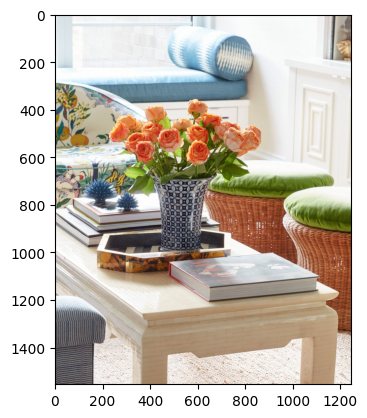

In [94]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

dom_data = "/kaggle/input/domestic-table/domestic_table_image_dataset/"
images = os.listdir(dom_data)
img1_name = images[1]
print (img1_name)


img1_data = cv.cvtColor(cv.imread(dom_data + img1_name), cv.COLOR_BGR2RGB)
print (img1_data.shape)
plt.imshow(img1_data)

In [95]:
# function for plotting bounding box
def plot_bbox(image_path, coord):
    image = cv.imread(image_path)
    # Draw bounding box
    x1, y1, x2, y2 = coord
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    # Convert BGR image to RGB
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    print (image_rgb.shape)

    # Plot the final image with bounding box
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

Detected vase with confidence 1.0 at location [421.49, 675.04, 670.87, 1006.04]
(1555, 1244, 3)


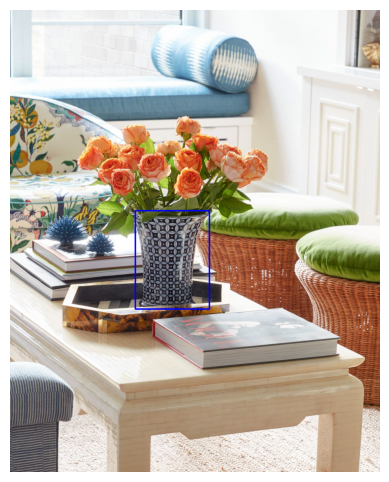

Detected book with confidence 0.976 at location [52.02, 763.02, 443.35, 908.53]
(1555, 1244, 3)


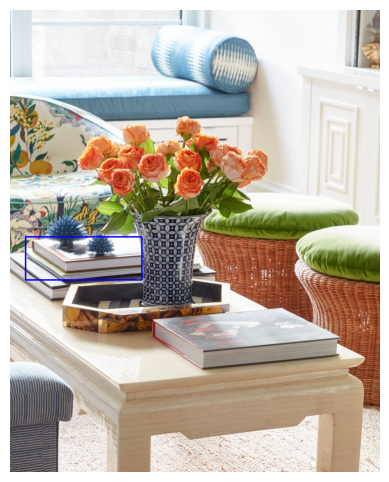

Detected couch with confidence 0.967 at location [-1.43, 208.83, 819.83, 377.89]
(1555, 1244, 3)


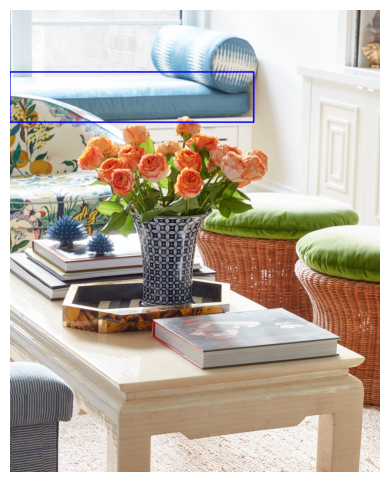

Detected book with confidence 0.995 at location [475.28, 990.53, 1121.61, 1215.52]
(1555, 1244, 3)


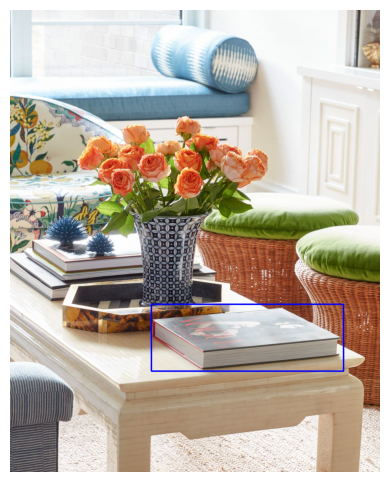

In [96]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

image_path = dom_data + img1_name

image = Image.open(image_path)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
    plot_bbox(image_path, box)

In [97]:
print (results)
print (type(results))

{'scores': tensor([0.9997, 0.9763, 0.9666, 0.9951], grad_fn=<IndexBackward0>), 'labels': tensor([86, 84, 63, 84]), 'boxes': tensor([[ 421.4871,  675.0427,  670.8736, 1006.0414],
        [  52.0248,  763.0236,  443.3510,  908.5338],
        [  -1.4319,  208.8314,  819.8349,  377.8879],
        [ 475.2849,  990.5282, 1121.6116, 1215.5192]],
       grad_fn=<IndexBackward0>)}
<class 'dict'>


In [98]:
# getting labels
def get_labels(lab_list):
    labels = []
    for label in lab_list:
        labels.append(model.config.id2label[label.item()])
        print (model.config.id2label[label.item()])
    return (labels)

In [99]:
var1 = results['boxes']
for i in var1:
    print (i)

tensor([ 421.4871,  675.0427,  670.8736, 1006.0414], grad_fn=<UnbindBackward0>)
tensor([ 52.0248, 763.0236, 443.3510, 908.5338], grad_fn=<UnbindBackward0>)
tensor([ -1.4319, 208.8314, 819.8349, 377.8879], grad_fn=<UnbindBackward0>)
tensor([ 475.2849,  990.5282, 1121.6116, 1215.5192], grad_fn=<UnbindBackward0>)


In [100]:
get_labels(results['labels'])

vase
book
couch
book


['vase', 'book', 'couch', 'book']

In [101]:
# getting index of items
def get_index(obj_list):
    index_list = []
    domestic_items = ["cup", "book", "vase", "pen", "remote"]
    counter = 0
    for _ in obj_list:
        if obj_list[counter] in domestic_items:
            index_list.append(counter)
        counter = counter + 1
    return index_list

In [102]:
# getting coordinates for specific objects
def get_coord(coord_list, index_list):
    coord_list_fin = []
    for i in index_list:
        coord_list_fin.append(coord_list[i])
    return coord_list_fin

In [103]:
final_coord = get_coord(results['boxes'], get_index(get_labels(results['labels'])))
final_coord

vase
book
couch
book


[tensor([ 421.4871,  675.0427,  670.8736, 1006.0414], grad_fn=<SelectBackward0>),
 tensor([ 52.0248, 763.0236, 443.3510, 908.5338], grad_fn=<SelectBackward0>),
 tensor([ 475.2849,  990.5282, 1121.6116, 1215.5192], grad_fn=<SelectBackward0>)]

In [104]:
for i in final_coord:
    print (i)

tensor([ 421.4871,  675.0427,  670.8736, 1006.0414], grad_fn=<SelectBackward0>)
tensor([ 52.0248, 763.0236, 443.3510, 908.5338], grad_fn=<SelectBackward0>)
tensor([ 475.2849,  990.5282, 1121.6116, 1215.5192], grad_fn=<SelectBackward0>)


In [105]:
# function for plotting bounding box
def plot_bbox_slctd(image_path, coord):
    image = cv.imread(image_path)
    for i in coord:
        # Draw bounding box
        x1, y1, x2, y2 = i
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

        # Convert BGR image to RGB
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        print (image_rgb.shape)

    # Plot the final image with bounding box
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

(1555, 1244, 3)
(1555, 1244, 3)
(1555, 1244, 3)


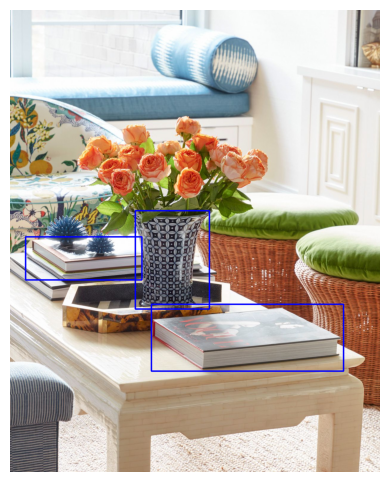

In [106]:
plot_bbox_slctd(image_path, final_coord)